In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import *
from models import *
from utils import *

# torch._dynamo.config.suppress_errors = True

Load dataset:

In [2]:
data_size = 2_097_152
data_gen = single_random_ring(N=32)
X, y = data_gen.generate_dataset(data_size=data_size, noise=True, sigma=0.3, features_degree=2, seed=42, device='cpu', test_return=True)
data_gen.noise_delta

{'mse_loss': {'mean': 0.003375522093847394, 'std': 0.0009824438020586967},
 'l1_loss': {'mean': 0.017874665558338165, 'std': 0.004685965832322836}}

[[10.         13.          7.2157087   1.57616     3.647382    0.36553982]
 [11.          9.          8.785421    0.91303724  1.7065285   0.04923379]
 [13.         13.          8.269556    0.84110016  3.8971128   0.02174723]
 ...
 [10.         11.          7.0380893   1.4298477   0.64752454  0.41258407]
 [ 9.          9.          8.301227    1.3721694   3.0532765   0.45067504]
 [ 9.         13.          7.4534225   1.2693497   1.0790293   0.39076206]]
[[0.         0.28571429 0.71428571 ... 0.33697903 0.42454017 0.53447782]
 [0.         0.42857143 0.14285714 ... 0.07376791 0.02675344 0.00969587]
 [0.         0.71428571 0.71428571 ... 0.38470367 0.0269867  0.00189177]
 ...
 [0.         0.28571429 0.42857143 ... 0.01062069 0.08506904 0.68090293]
 [0.         0.14285714 0.14285714 ... 0.23614168 0.43815976 0.81243255]
 [0.         0.14285714 0.71428571 ... 0.02949218 0.13426057 0.61078039]]


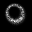

In [3]:
features, transformed_features, imgs = data_gen.random_sample(256)
print(features)
print(transformed_features)
Image.fromarray((imgs[0] * 255 / imgs[0].max()).astype(np.uint8))

Test generator:

In [4]:
# load generator
generator = DGBaNConv33()
# generator = torch.compile(generator)

pre_trained_weights = torch.load(
    '../save_data/single_random_ring/Adam_mse_loss_0/DGBaNConv33_no_activation_function/DGBaNConv33_no_activation_function_10.pt',
    map_location=torch.device('cpu')
)
generator.load_state_dict(pre_trained_weights)

print(generator.eval())
print(f'Number of parameters: {count_params(generator):,}')

DGBaNConv33(
  (linear_layers): NLinearNormAct(
    (linear_act): ModuleList(
      (0): LinearReparameterization()
      (1): ReLU()
      (2): LinearReparameterization()
      (3): ReLU()
      (4): LinearReparameterization()
      (5): ReLU()
      (6): LinearReparameterization()
      (7): ReLU()
      (8): LinearReparameterization()
      (9): ReLU()
      (10): LinearReparameterization()
      (11): ReLU()
    )
  )
  (conv_layers): BayesSequential(
    (bayes_modules): ModuleList(
      (0): BottleNeck(
        (block): ResidualAdd(
          (block): BayesSequential(
            (bayes_modules): ModuleList(
              (0-1): 2 x ConvNormAct(
                (conv): ConvTranspose2dReparameterization()
                (norm_act): Sequential(
                  (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (1): ReLU()
                )
              )
              (2): ConvNormAct(
                (conv): ConvTranspose2d

0.008972821
0.064884484
0.02603478


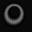

In [5]:
mse_loss = []
l1_loss = []
AbsMeanDelta = []
for i in range(1):
    y_pred = generator(torch.Tensor(transformed_features[:1]))[0].detach().numpy().squeeze()
    mse_loss.append(((y_pred - imgs[0])**2).mean())
    l1_loss.append(abs(y_pred - imgs[0]).mean())
    AbsMeanDelta.append(abs((y_pred - imgs[0]).mean()))
 
print(np.mean(mse_loss))
print(np.mean(l1_loss))
print(np.mean(AbsMeanDelta))
Image.fromarray(abs(y_pred * 255).astype(np.uint8))

In [6]:
n_samples = 1000

# getting the predictions for this feature
pred_rings = torch.zeros((n_samples, 32, 32), dtype=torch.float, device='cpu')
X = torch.Tensor(transformed_features[:1])
with torch.no_grad():
    for j in range(n_samples):
        pred_rings[j] += generator(X)[0].squeeze()

pred_rings = pred_rings.detach().numpy()

pred_ring = pred_rings.mean(axis=0) * 255
true_img = data_gen.ring_from_features(*features[0])
true_ring = true_img * 255

In [7]:
n_samples = data_gen.kernel.shape[0] // 20

# getting the predictions for this feature
true_prob_samples = torch.zeros((n_samples, 32, 32))
for j in range(n_samples):
    true_prob_samples[j] += true_img * data_gen.kernel[j].reshape((32, 32))

true_prob_samples = true_prob_samples.numpy()

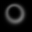

In [8]:
# predicted gaussian ring
Image.fromarray(abs(pred_ring).astype(np.uint8))

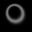

In [9]:
# true gaussian ring
Image.fromarray(true_ring.numpy().astype(np.uint8))

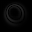

In [10]:
# difference between the rings
Image.fromarray(np.abs(true_ring.numpy() - pred_ring).astype(np.uint8))

In [11]:
# MSE error
((pred_ring / pred_ring.max() - true_ring.numpy() / true_ring.numpy().max())**2).mean()

0.006300538

(16, 21)


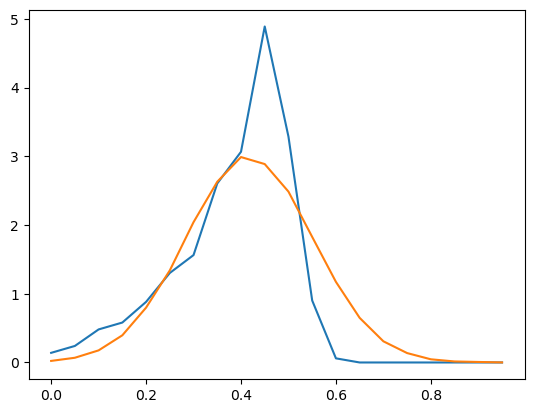

In [46]:
# getting the distribution for one pmt
pmt = (0, 0)
while true_ring[pmt] < 0.4 * 255:
    pmt = (np.random.randint(32), np.random.randint(32))
print(pmt)

hist_width = 0.05

# predictited distribution
pred = pd.Series(pred_rings[:, pmt[0], pmt[1]])
hist = pd.Series(1, index=pd.cut(pred, np.arange(0, 1.005, hist_width))).sort_index().groupby(level=0).sum()
pred_noise = hist / (hist.sum() * hist_width)
plt.plot(np.arange(0, 1, hist_width), pred_noise)

# true distribution
true = pd.Series(true_prob_samples[:, pmt[0], pmt[1]])
true_hist = pd.Series(1, index=pd.cut(true, np.arange(0, 1.005, hist_width))).sort_index().groupby(level=0).sum()
true_noise = true_hist / (true_hist.sum() * hist_width)
plt.plot(np.arange(0, 1, hist_width), true_noise)
plt.show()